# International Arctic Buoy Programme - Near-Real-Time Buoy Positions for Ice Motion Validation

### Initial Setup:
```
conda create -n py3-iabp python=3 matplotlib pandas cartopy geopandas jupyter
activate py3-iabp
jupyter notebook
```

In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
from geopandas import GeoDataFrame
from shapely.geometry import Point
from shapely.geometry import LineString

In [2]:
FILE_TO_GET = 'C2018'
BEGIN_DATE_SLICE = pd.datetime(2018,10,15)

## <font color='red'>IABP FTP is shut down as of Oct 1, 2018</font>

In [3]:
#### Connect to the IABP FTP, retrieve and store the contents of the requested file in a bytes object
#ftp_host = 'iabp.apl.washington.edu'
#ftp_file = f'pub/IABP/C/{FILE_TO_GET}'
#with FTP(ftp_host) as ftp:
#    ftp.login()
#    data = BytesIO()
#    ftp.retrbinary(f'RETR {ftp_file}', data.write)
#data.seek(0)
#lines = data.read().split(b'\n')[:-1]

## Use the IABP http server instead 👍

In [4]:
iabp_url = 'http://iabp.apl.washington.edu/Data_Products/C/{FILE_TO_GET}.dat'
r = requests.get(
    iabp_url.format(FILE_TO_GET=FILE_TO_GET)
)
print(f'HTTP-{r.status_code}: {r.reason}')

HTTP-200: OK


In [5]:
lines = r.content.split(b'\n')[:-1]
print(f'Example line:\n{lines[-1]}')

Example line:
b'2018 10 30 00 300234066836600 76.60344 -164.21480'


#### Sometimes there are stream errors in the remote data file (shown as &#xfffd; in lines) that we have to account for
#### We also split each valid line to get rid of whitespace chars

In [6]:
good_lines_split = [l.split() for l in lines if b'\x00' not in l]
print(f'Example of a "good" line:\n{good_lines_split[-1]}')

Example of a "good" line:
[b'2018', b'10', b'30', b'00', b'300234066836600', b'76.60344', b'-164.21480']


#### Each data column gets converted from binary string to a more apt datatype

In [7]:
arr = np.array(good_lines_split).T # transpose rows to columns
years, months, days, hours = arr[:4,:].astype(int) # first 4 columns are the time info
ids = arr[4,:].astype('int64') # 5th column is the buoy ID
lats, lons = arr[5:,:].astype('float64') # 6th and 7th columns are latitude and longitude

#### Setup the basic dataframe structure, calculate a datetime64[ns] column so we can drop the individual Year/Month/Day/Hour columns

In [8]:
df = pd.DataFrame({'YEAR':pd.Series(years, dtype='str'),
                   'MONTH':pd.Series(months, dtype='str'),
                   'DAY':pd.Series(days, dtype='str'),
                   'HOUR':pd.Series(hours, dtype='str'),
                   'BUOY_ID':pd.Series(ids, dtype='uint64'),
                   'LAT':pd.Series(lats, dtype='float64'),
                   'LON':pd.Series(lons, dtype='float64')})
df['timestamp'] = pd.to_datetime(df.YEAR + '-' + df.MONTH + '-' + df.DAY + ' ' + df.HOUR + ':00:00')
df = df.drop(['YEAR', 'MONTH', 'DAY', 'HOUR'], axis=1)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94758 entries, 0 to 94757
Data columns (total 4 columns):
BUOY_ID      94758 non-null uint64
LAT          94758 non-null float64
LON          94758 non-null float64
timestamp    94758 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(2), uint64(1)
memory usage: 2.9 MB


In [10]:
df.tail(5)

,BUOY_ID,LAT,LON,timestamp
94753,300234066309590,84.39056,-60.17353,2018-10-30
94754,300234066345810,81.66020,172.07900,2018-10-30
94755,300234066830700,87.79644,-11.48431,2018-10-30
94756,300234066833600,80.87914,-98.86650,2018-10-30
94757,300234066836600,76.60344,-164.21480,2018-10-30


#### Convert to a geodataframe so we can easily plot the buoy locations

In [11]:
geometry = [Point(xy) for xy in zip(df.LON, df.LAT)]
src_crs = {'init': 'epsg:4326'}
fig_crs = ccrs.NorthPolarStereo(central_longitude=-90, true_scale_latitude=70)
gdf = GeoDataFrame(data=df.drop(['LAT','LON'], axis=1), crs=src_crs, geometry=geometry)
gdf = gdf.to_crs(fig_crs.proj4_init)
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 94758 entries, 0 to 94757
Data columns (total 3 columns):
BUOY_ID      94758 non-null uint64
timestamp    94758 non-null datetime64[ns]
geometry     94758 non-null object
dtypes: datetime64[ns](1), object(1), uint64(1)
memory usage: 2.2+ MB


In [16]:
def plot_buoys(dframe):
    sub = gdf.loc[gdf.timestamp >= BEGIN_DATE_SLICE]
    LATEST_DATE = sub.timestamp.max()
    sub = sub.loc[sub.timestamp <= LATEST_DATE]
    buoy_id_list = sorted(sub.BUOY_ID.unique().tolist())

    fig, ax = plt.subplots(figsize=(10,10), subplot_kw={'projection': fig_crs})
    ax.set_extent([-3000000,3500000,-3500000,3000000], crs=fig_crs)
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
    ax.add_feature(cfeature.LAND.with_scale('50m'))
    ax.add_feature(cfeature.OCEAN.with_scale('50m'))
    for buoy in buoy_id_list:
        bgdf = sub.loc[gdf.BUOY_ID == buoy]
        bgdf = bgdf.sort_values(by='timestamp')
        # Generate linestring geometries for the buoy-trail only if there are >= 2 timesteps
        if len(bgdf) > 2:
            line_geom = LineString(bgdf.iloc[:-1]['geometry'].tolist())
            vertex_count = len(line_geom.coords)
            # skip the weird buoys that go over a million km in only a few timesteps
            # unfortunately doesn't catch all the weird displacements
            if line_geom.length > 1e6 and vertex_count < 20:
                print(f'Weird buoy -> {buoy} {line_geom.length} {vertex_count}')
                continue
            else:
                xs, ys = line_geom.xy
                ax.plot(xs, ys, transform=fig_crs, color='k', linestyle='-')
        latest_point = bgdf.iloc[-1]['geometry']
        ax.plot(latest_point.x, latest_point.y, 'o', color='#990101', transform=fig_crs, markersize=5)
        ax.set_title(f'IABP Buoy tracks from {BEGIN_DATE_SLICE.date()} to {LATEST_DATE.date()}', size=16)

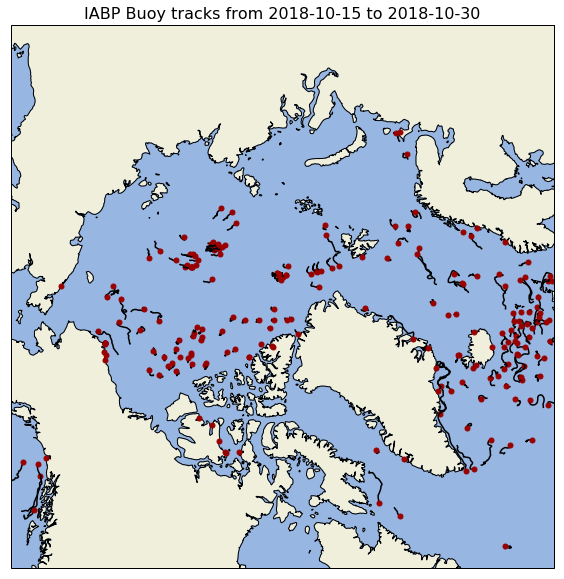

In [17]:
plot_buoys(gdf)